# Problem Statement

An insurance company needs an automated system to estimate the annual medical expenditure for new customers using information such as their age, sex, BMI, children, smoking habits and region of residence.

Estimates from the system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. Due to the regulatory requirements, you must be able to explain why your system outouts a certain prediction.

In [60]:
import duckdb
import pandas as pd
import requests
import time
import io 

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data

A csv file containing verified historical data mentioned above. Includes 1300+ customers.

In [5]:
data_url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"

def data_download(url: str, timeout: int = 10)->pd.DataFrame | None:

    try:
        response = requests.get(url, timeout=timeout)
        response.raise_for_status()  # Raises HTTPError for bad responses
        return pd.read_csv(io.StringIO(response.text))
    except requests.exceptions.RequestException as e:
        print(f"Download failed: {e}")
        return None

data = data_download(data_url)

In [6]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Look at the details of the dataset

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## Exploratory analysis

Age

In [20]:
data.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

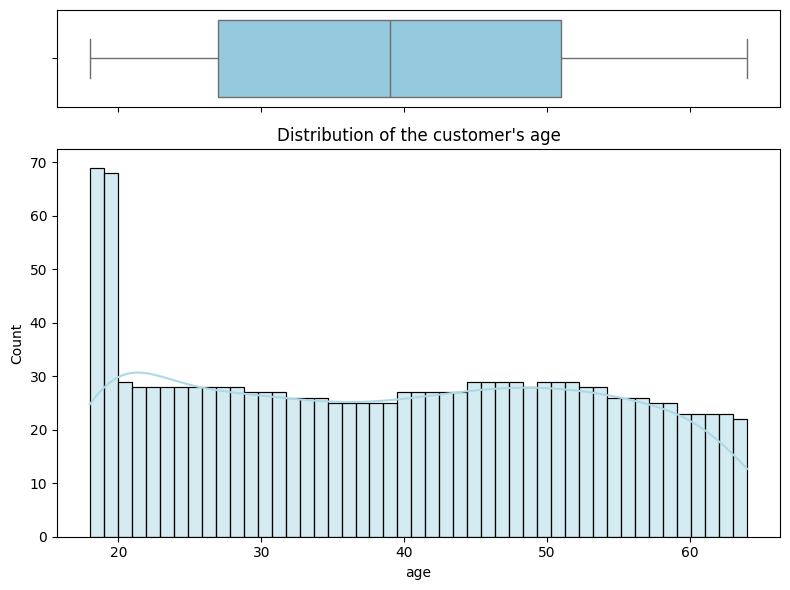

In [24]:
# Set up the figure with subplots
fig, (ax_box, ax_hist) = plt.subplots(
    nrows=2, 
    sharex=True, 
    gridspec_kw={"height_ratios": (0.2, 0.8)}, 
    figsize=(8, 6)
)

# Boxplot on top
sns.boxplot(data=data, x="age", ax=ax_box, color="skyblue")
ax_box.set(xlabel='')  # Remove x-axis label on boxplot

# Histogram below
sns.histplot(data=data, x="age", bins=(64-18)+1, kde=False, ax=ax_hist, color="lightblue")

# Titles
ax_hist.set_title("Distribution of the customer's age")

plt.tight_layout()
plt.show()

A similar analysis can be done for other variables

In [9]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Let us pick one of those, our target variable--charges

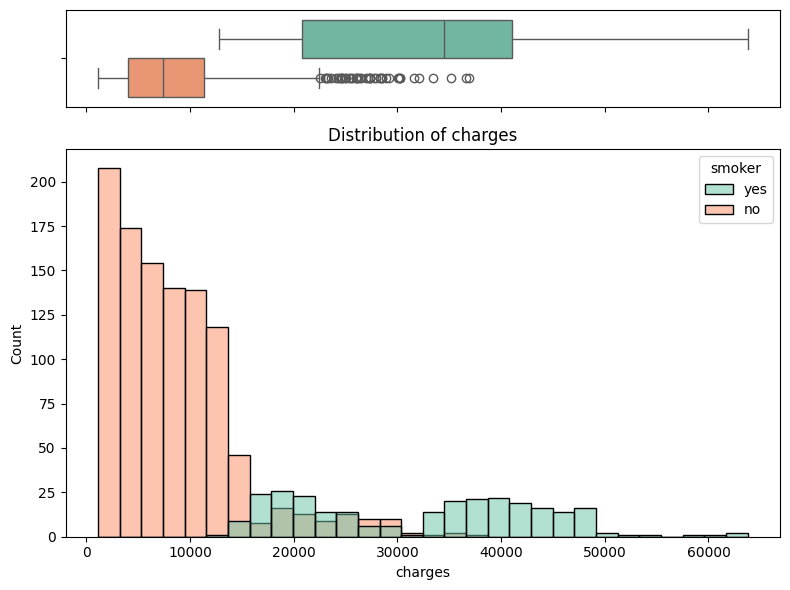

In [35]:
# Set up the figure with subplots
fig, (ax_box, ax_hist) = plt.subplots(
    nrows=2, 
    sharex=True, 
    gridspec_kw={"height_ratios": (0.2, 0.8)}, 
    figsize=(8, 6)
)

# Boxplot on top
sns.boxplot(data=data, x="charges", hue="smoker", legend=False, ax=ax_box, palette="Set2", orient="h")
ax_box.set(xlabel='')  # Remove x-axis label on boxplot

# Histogram below
sns.histplot(data=data, x="charges", hue="smoker", legend=True, kde=False, ax=ax_hist,  palette="Set2")

# Titles
ax_hist.set_title("Distribution of charges")

plt.tight_layout()
plt.show()

More similar exploration can be done with the other variables.

## Simple linear regression

Using age to predict the annual charges.

Both Age and charges are numerical variables. We can start by visualizing their relationship.

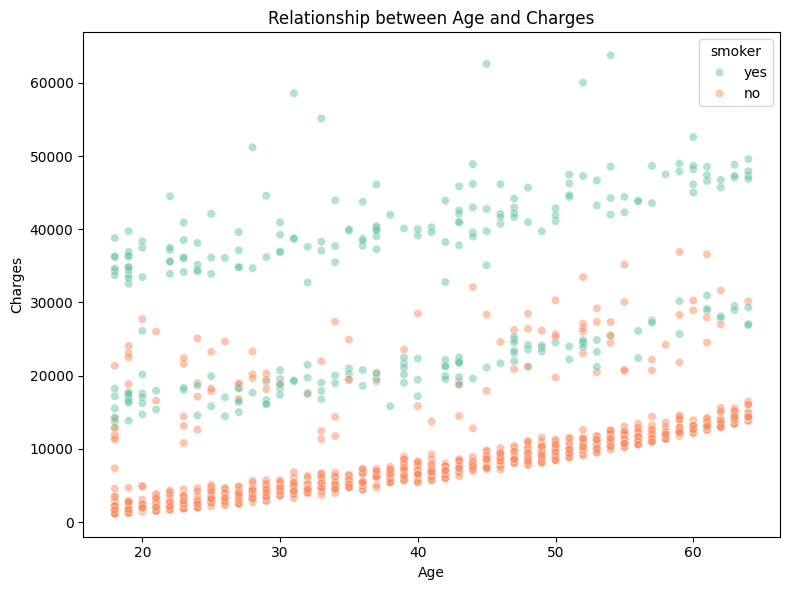

In [69]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x="age", y="charges", hue="smoker", palette="Set2", alpha=0.5,)

plt.title("Relationship between Age and Charges")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.tight_layout()
plt.show()

There seems to be some pattern: the older one gets, the higher the charges. It also seems that non-smokers tend to have lower charges than the smokers. The pattern is not very clear so some more investigation may need to be done.

Putting a measure to the relation ship between Age and charges, we see a weak (0.299) positive correlation.

In [48]:
float(data.charges.corr(data.age))

0.2990081933306476

From the scatter plot and the correlation coefficient. Age on its own does not seem to be a good predictor of insurance charges. Nevertheless, we proceeed to fit the simple linear regression (\$charges = intercept + slope*age\$) just to see the output. Fitting separate lines for smokers and non-smokers makes sense just by looking at the possible clusters on the scatter plot.

We start by filtering the data we need. For exploratory purposes, we compare using pandas and duckdb and pick the implementation that is quicker. Interesting, for this case the pandas implementation is quicker. 

In [71]:
# filtering Experiment with pandas vs duckdb
# Pandas
start = time.time()
data_filtered = data[data.smoker == 'no']
end = time.time()

print(f"Pandas filtering took {end - start:.6f} seconds")

# duckdb
start = time.time()
data_filtered_duckdb = duckdb.query("""
    SELECT * FROM data WHERE smoker = 'no'
""").to_df()
end = time.time()

print(f"DuckDB filtering took {end - start:.6f} seconds")

Pandas filtering took 0.010457 seconds
DuckDB filtering took 0.058978 seconds


### Import libraries

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### Fit the model

In [74]:
# Features (X) and target (y)
X = data_filtered[["age"]]     # Predictor must be 2D
y = data_filtered["charges"]   # Target

In [78]:
model = LinearRegression()
model.fit(X, y)

print(f"Intercept: {model.intercept_:.2f}")
print(f"Slope: {model.coef_[0]:.2f}")

Intercept: -2091.42
Slope: 267.25


The Intercept (negative) in this case makes no practical sense, especially if we start from the assumption of zero age.

### Make predictions


In [79]:
y_pred = model.predict(X)

### Plot the regression line

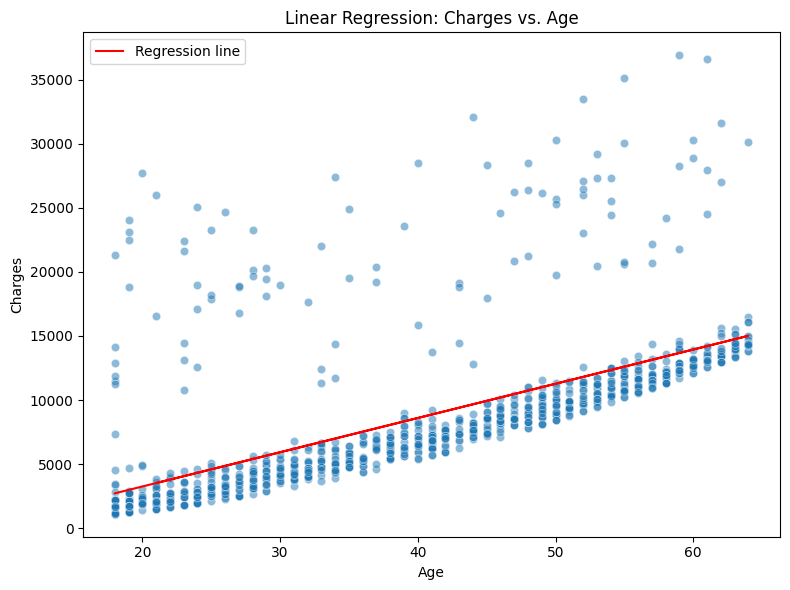

In [80]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="age", y="charges", data=data_filtered, alpha=0.5)
plt.plot(data_filtered["age"], y_pred, color="red", label="Regression line")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.title("Linear Regression: Charges vs. Age")
plt.legend()
plt.tight_layout()
plt.show()

## Multiple linear regression

We can have a quick look at the correlation bewtween our variables here.

In [54]:
correlation_matrix = data.corr(numeric_only=True)
print(correlation_matrix)

               age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000


Text(0.5, 1.0, 'Correlation Matrix')

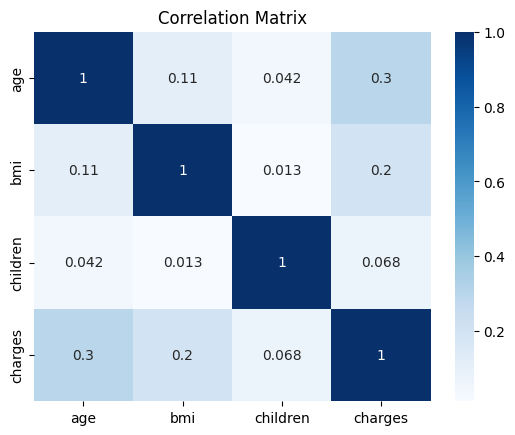

In [58]:
sns.heatmap(correlation_matrix, cmap ="Blues", annot = True)
plt.title("Correlation Matrix")

Alwasys remember that correlation does not imply causality.

In [ ]:
data_filtered = data[data.smoker == 'no']